# 7. 数据透视表

数据透视表（pivot table）是一种类似于GroupBy，但是更加灵活的操作方法，常见于Excel等表哥应用中，可以理解为多维的GroupBy。

本节演示数据集为 titanic 数据，也可以通过 Seaborn 程序库获取：

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

In [ ]:
titanic = sns.load_dataset('titanic')

titanic

统计不同性别乘客的生还率：

In [ ]:
titanic.groupby('sex')['survived'].mean()

统计不同仓位、不同性别的生还率：

In [ ]:
titanic.groupby(['class','sex'])['survived'].mean().unstack()

如果用透视表完成上述统计，应该为：

In [ ]:
titanic.pivot_table('survived', index='sex', columns='class')

由此可见，pivot_table() 自动对统计数据取均值。

如果此时增加一个年龄字段作为第三个统计维度，也能用透视表轻松实现：

In [ ]:
# 首先对年龄分层

age = pd.cut(titanic['age'], [0,18,80])
titanic.pivot_table('survived', ['sex',age], 'class')

用 groupby 也能轻松实现：

In [ ]:
titanic.groupby(['sex', age, 'class'])['survived'].mean().unstack()

再将船票价格按照计数等分为两份，加入数据透视表：

In [ ]:
fare = pd.qcut(titanic['fare'], 2)
titanic.pivot_table('survived', ['sex', age], [fare, 'class'])

上述功能也可以用 groupby 实现：

In [ ]:
titanic.groupby(['sex', age, fare, 'class'])['survived'].mean().unstack().unstack()

由此可见，groupby 与 pivot_table 的主要区别在于透视表能够指定行、列，句法比较清晰。

透视表还能够对不同列指定不同对累计函数：

In [ ]:
titanic.pivot_table(index='sex', columns='class', aggfunc={'survived':sum, 'fare':'mean'})

同时，透视表还可以通过 margins 参数设置计算每一行和每一列的总数，类似于 SQL 中的 with rollup 语句，展示比 SQL 更直观、可读性更强：

In [ ]:
titanic.pivot_table('survived', index='sex', columns='class', margins=True)

【案例】用透视表分析美国出生数据

In [6]:
births = pd.read_csv('births.csv')
births.head()
births.describe()

,year,month,day,births
count,15547.000000,15547.000000,15067.000000,15547.000000
mean,1979.037435,6.515919,17.769894,9762.293561
std,6.728340,3.449632,15.284034,28552.465810
min,1969.000000,1.000000,1.000000,1.000000
25%,1974.000000,4.000000,8.000000,4358.000000
50%,1979.000000,7.000000,16.000000,4814.000000
75%,1984.000000,10.000000,24.000000,5289.500000
max,2008.000000,12.000000,99.000000,199622.000000


先按年代统计出生人数：

In [11]:
births['decade'] = 10 * (births['year'] // 10)
births['decade'] = births['decade'].astype(str) + 's'
births.pivot_table('births', index='decade', columns='gender', aggfunc='sum')

gender,F,M
decade,,
1960s,1752836,1845742
1970s,16260348,17118785
1980s,16336507,17171290


统计每年不同性别的出生人数，并画图：

In [ ]:
import matplotlib.pyplot as plt
sns.set()
table = births.pivot_table('births', index='year', columns='gender', aggfunc='sum')
#table
table.plot()
plt.ylabel('total births per year')

In [ ]:
# 多条件筛选必须加 ()
births[(births['year'] > 1980) & (births['year'] < 1990)]

画出不同年代不同星期的日均出生数据

In [9]:
import matplotlib.pyplot as plt
import matplotlib as mpl

尝试用日期构建一个星期的索引，发现 day 中有缺失值，需要去掉。这里采用 sigma 消除法（sigma-clipping），按照正态分布标准差划定范围，只取均值左右五个标准差范围内的数据。

In [8]:
quartiles = np.percentile(births['births'], [25, 50, 75])
# 均值，等同于births['births'].median()
mu = quatiles[1]
# print('mu: '+mu.astype(str))
sig = 0.74 * (quartiles[2] - quartiles[0])
births = births.query('(births > @mu - 5 * @sig) & (births < @mu + 5 * @sig)' )
births.describe()

,year,month,day,births
count,14610.000000,14610.000000,14610.000000,14610.000000
mean,1978.501027,6.522930,15.729637,4824.470089
std,5.766538,3.448821,8.800393,579.996983
min,1969.000000,1.000000,1.000000,3249.000000
25%,1974.000000,4.000000,8.000000,4383.000000
50%,1979.000000,7.000000,16.000000,4812.000000
75%,1984.000000,10.000000,23.000000,5259.000000
max,1988.000000,12.000000,31.000000,6527.000000


In [21]:
births['day']=births['day'].astype(int)
births.index = pd.to_datetime(10000 * births.year + 100 * births.month + births.day, format='%Y%m%d')
print(births.index[0].year)

1969


Text(0, 0.5, 'mean births by day')

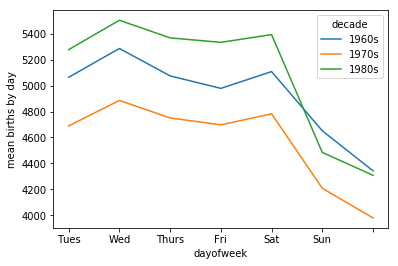

In [22]:
births['dayofweek'] = births.index.dayofweek
births.pivot_table('births', index='dayofweek', columns='decade', aggfunc='mean').plot()
plt.gca().set_xticklabels(['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])
plt.ylabel('mean births by day')

另一个有趣的图标是画出各个年份平均每天的出生人数，按照月和日两个维度分别对数据进行分组：

In [33]:
births_by_date = births.pivot_table('births', [births.index.month, births.index.day])
births_by_date.head()

births
1 1  4009.225
  2  4247.400
  3  4500.900
  4  4571.350
  5  4603.625

In [35]:
# 构建一个虚拟索引，将出生日期统一到一年中，因为年份此时变得不重要
# 但是必须是闰年，因为有2月29日，否则会报错
births_by_date.index = [pd.datetime(2016, month, day) 
                       for (month, day) in births_by_date.index]
births_by_date.head()

,births
2016-01-01,4009.225
2016-01-02,4247.400
2016-01-03,4500.900
2016-01-04,4571.350
2016-01-05,4603.625


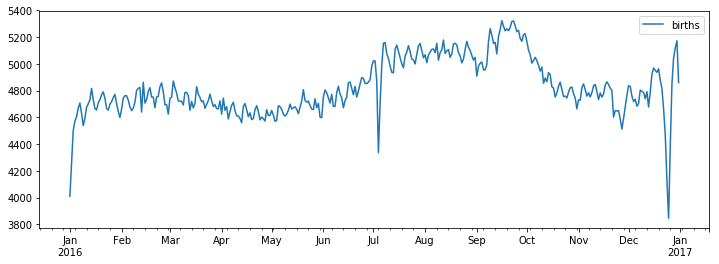

In [36]:
fig,ax = plt.subplots(figsize=(12,4))
births_by_date.plot(ax=ax);